In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, roc_curve
)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

# set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100


In [3]:
df = pd.read_csv("../data/diabetes_dataset.csv")
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

TARGET_COL = "diagnosed_diabetes"

if TARGET_COL not in df.columns:
    raise ValueError(f"'{TARGET_COL}' not found in columns: {list(df.columns)[:10]} ...")


DATASET OVERVIEW
Shape: (100000, 31)

First few rows:
   age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   48  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Retired   
4   46    Male     White        Graduate        Middle           Retired   

  smoking_status  alcohol_consumption_per_week  \
0          Never                             0   
1         Former                             1   
2          Never                             1   
3          Never                             0   
4          Never                             1   

   physical_activity_minutes_per_week  diet_score  ...  hdl_cholesterol  \
0                                 215         5.7  ...               41   
1                                 143 

In [4]:
print("\n" + "=" * 80)
print("CHECKING FOR POTENTIAL DATA LEAKAGE")
print("=" * 80)

# identify suspicious column names that might leak target information
leakage_keywords = ['diabetes', 'risk', 'stage', 'diagnosis', 'disease', 'condition']
suspicious_cols = []
for col in df.columns:
    if col != TARGET_COL:
        for keyword in leakage_keywords:
            if keyword.lower() in col.lower():
                suspicious_cols.append(col)
                break

if suspicious_cols:
    print(f"⚠️  WARNING: Found {len(suspicious_cols)} potentially leaky columns:")
    for col in suspicious_cols:
        print(f"  - {col}")
        # calculate correlation with target if numeric
        if df[col].dtype in ['int64', 'float64']:
            corr = df[col].corr(df[TARGET_COL].astype(int))
            print(f"    Correlation with target: {corr:.4f}")
    
else:
    print("✓ No obviously suspicious column names found")




CHECKING FOR POTENTIAL DATA LEAKAGE
⚠️  WARNING: Found 3 potentially leaky columns:
  - family_history_diabetes
    Correlation with target: 0.1979
  - diabetes_risk_score
    Correlation with target: 0.2773
  - diabetes_stage


In [5]:
y = df[TARGET_COL].astype(int).clip(0, 1)
print(f"\n{'=' * 80}")
print("TARGET DISTRIBUTION")
print("=" * 80)
print(f"Class counts (0=no diabetes, 1=has diabetes):\n{y.value_counts()}")
print(f"Class balance: {y.value_counts(normalize=True)}")
print(f"Imbalance ratio: {(y == 0).sum() / (y == 1).sum():.2f}:1")

# drop target and confirmed leakage columns
leakage_cols = {"diabetes_risk_score", "diabetes_stage", TARGET_COL}
leakage_cols.update(suspicious_cols)  # add any suspicious columns
X = df.drop(columns=[c for c in leakage_cols if c in df.columns])

print(f"\nRemoved columns: {[c for c in leakage_cols if c in df.columns]}")
print(f"Features remaining: {X.shape[1]}")



TARGET DISTRIBUTION
Class counts (0=no diabetes, 1=has diabetes):
diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64
Class balance: diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64
Imbalance ratio: 0.67:1

Removed columns: ['diabetes_stage', 'diagnosed_diabetes', 'family_history_diabetes', 'diabetes_risk_score']
Features remaining: 27


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Train set: 80000 samples
Test set: 20000 samples


In [7]:
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print(f"\nNumeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)



Numeric features: 21
Categorical features: 6


In [8]:
models = {}
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = max(1.0, neg / max(pos, 1))

# Logistic Regression
models["LogisticRegression"] = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=2000, class_weight="balanced", solver="lbfgs", random_state=42
    ))
])

# Random Forest
models["RandomForest"] = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, n_jobs=-1,
        class_weight="balanced_subsample", random_state=42
    ))
])

# XGBoost
models["XGBoost"] = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=spw
    ))
])

# LightGBM
models["LightGBM"] = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", lgb.LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        class_weight="balanced",
        verbose=-1
    ))
])


In [9]:
print("\n" + "=" * 80)
print("MODEL TRAINING AND EVALUATION")
print("=" * 80)

results = []
fitted_models = {}
all_probas = {}

for name, pipe in models.items():
    print(f"\n{'=' * 80}")
    print(f"Training: {name}")
    print("=" * 80)
    
    # fit model
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe
    
    # predictions
    y_pred = pipe.predict(X_test)
    
    # get probabilities
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        dec = pipe.decision_function(X_test)
        proba = 1 / (1 + np.exp(-dec))  # proper sigmoid transformation
    else:
        proba = None
    
    all_probas[name] = proba
    
    # calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    
    # cross-validation score (on training set)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"Cross-Val ROC-AUC: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall: {rec:.4f}")
    print(f"Test F1: {f1:.4f}")
    print(f"Test ROC-AUC: {roc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Specificity: {specificity:.4f}")
    
    results.append({
        "Model": name,
        "CV ROC-AUC": cv_mean,
        "CV Std": cv_std,
        "Test Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": roc,
        "Specificity": specificity
    })




MODEL TRAINING AND EVALUATION

Training: LogisticRegression
Cross-Val ROC-AUC: 0.9339 (+/- 0.0015)
Test Accuracy: 0.8864
Test Precision: 0.9291
Test Recall: 0.8778
Test F1: 0.9027
Test ROC-AUC: 0.9336
Specificity: 0.8995

Training: RandomForest
Cross-Val ROC-AUC: 0.9409 (+/- 0.0015)
Test Accuracy: 0.9197
Test Precision: 0.9996
Test Recall: 0.8665
Test F1: 0.9283
Test ROC-AUC: 0.9383
Specificity: 0.9995

Training: XGBoost
Cross-Val ROC-AUC: 0.9410 (+/- 0.0016)
Test Accuracy: 0.9196
Test Precision: 0.9994
Test Recall: 0.8666
Test F1: 0.9283
Test ROC-AUC: 0.9378
Specificity: 0.9992

Training: LightGBM
Cross-Val ROC-AUC: 0.9404 (+/- 0.0012)
Test Accuracy: 0.9197
Test Precision: 0.9993
Test Recall: 0.8668
Test F1: 0.9283
Test ROC-AUC: 0.9380
Specificity: 0.9991



MODEL COMPARISON SUMMARY
             Model  CV ROC-AUC   CV Std  Test Accuracy  Precision   Recall       F1  ROC-AUC  Specificity
      RandomForest    0.940866 0.001503        0.91970   0.999615 0.866500 0.928310 0.938273     0.999500
          LightGBM    0.940419 0.001198        0.91970   0.999327 0.866750 0.928329 0.938006     0.999125
           XGBoost    0.940982 0.001594        0.91965   0.999423 0.866583 0.928275 0.937816     0.999250
LogisticRegression    0.933885 0.001521        0.88645   0.929082 0.877750 0.902687 0.933611     0.899500


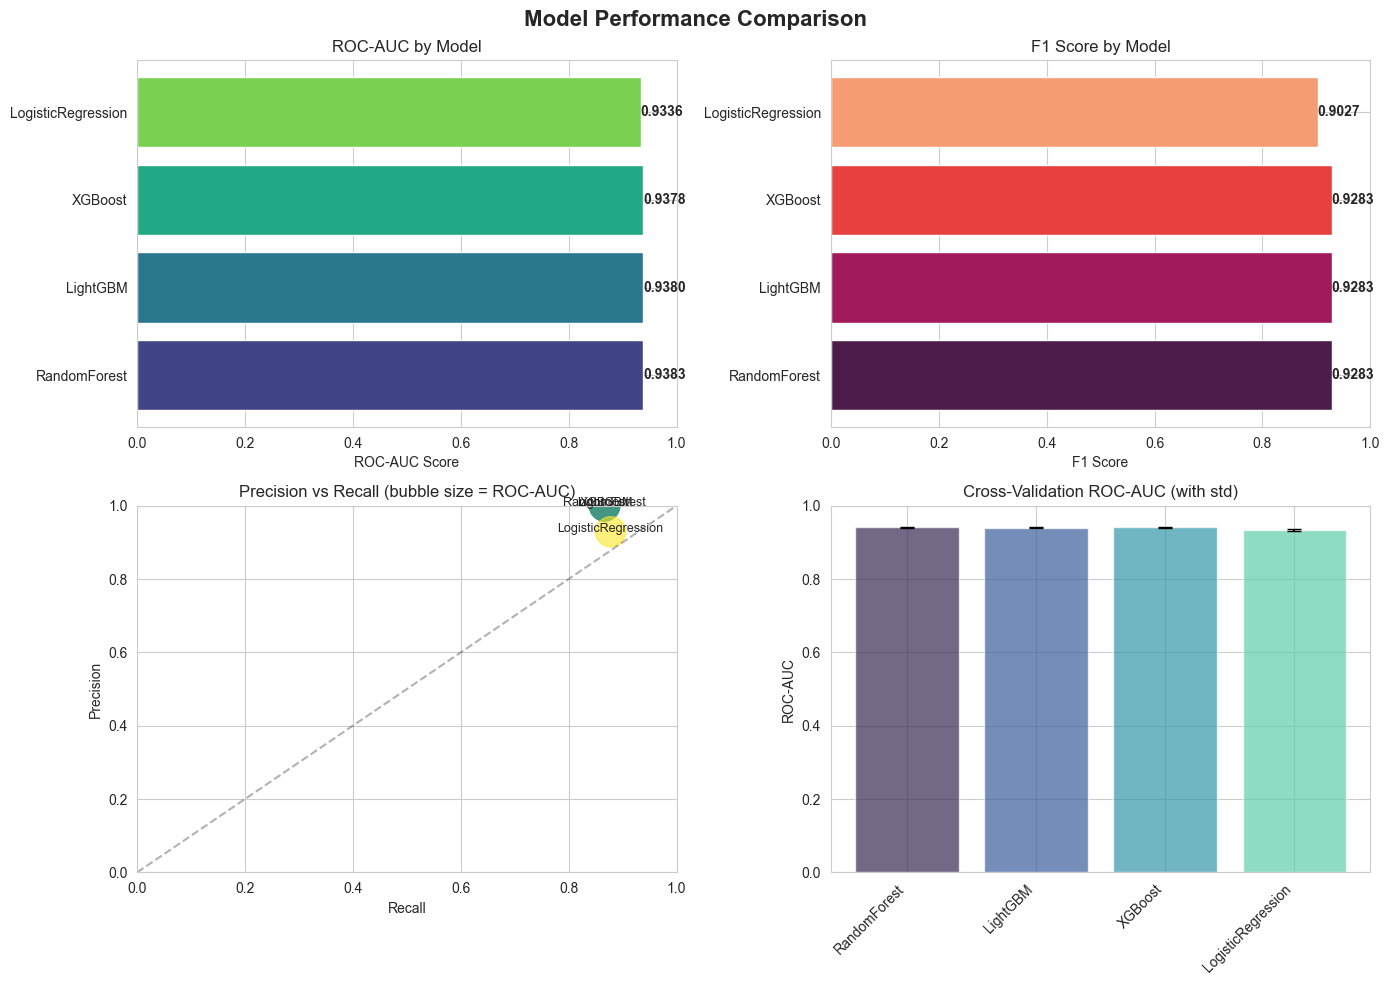

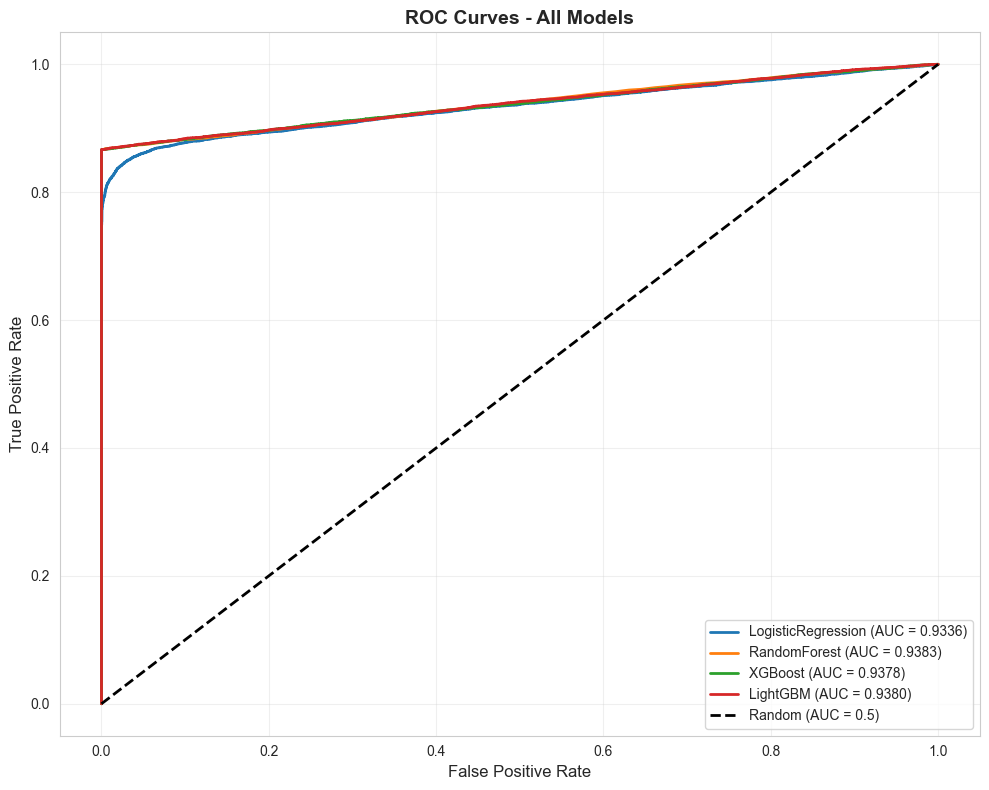

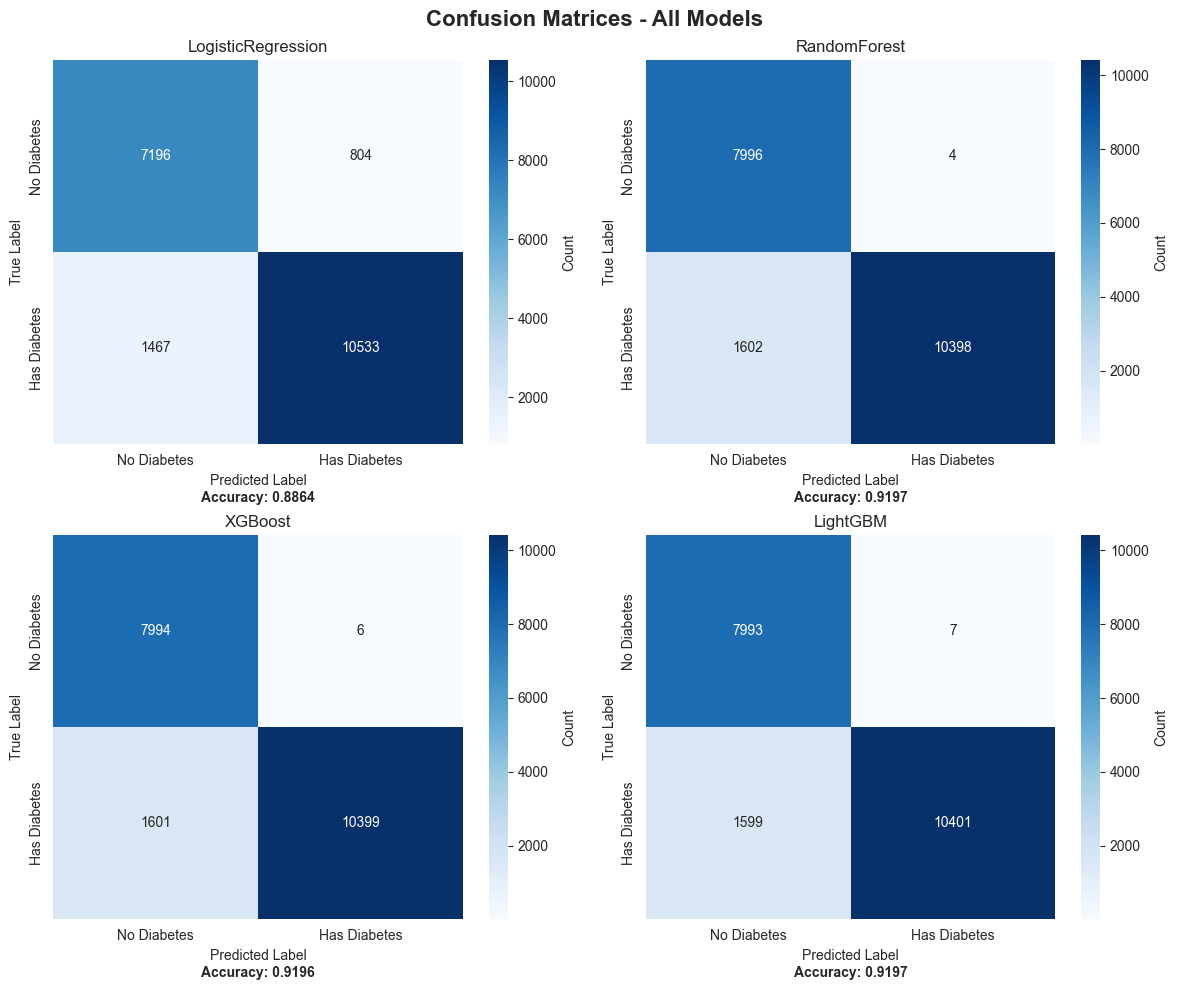

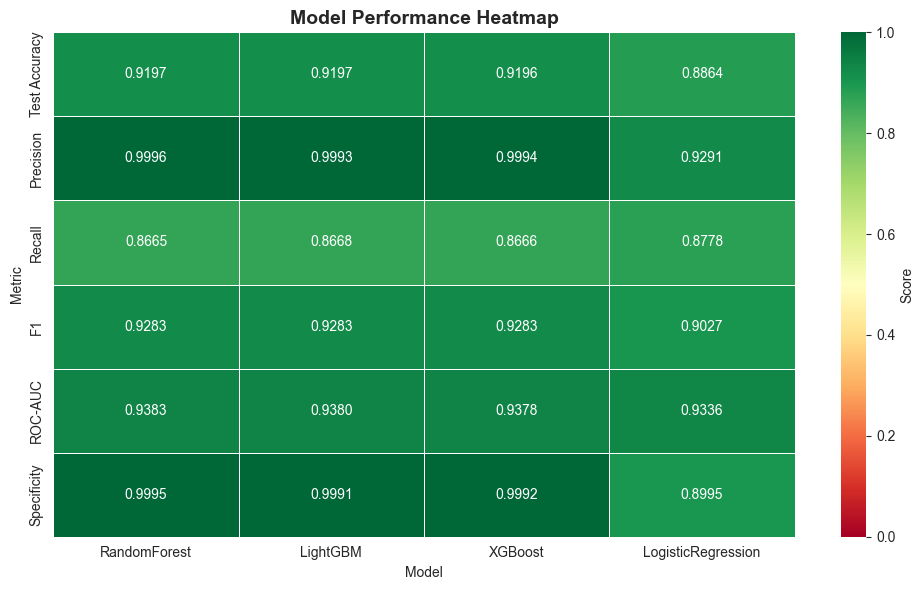

In [10]:
# summary DataFrame
summary = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(summary.to_string(index=False))

# visualization 1: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# ROC-AUC
ax = axes[0, 0]
bars = ax.barh(summary['Model'], summary['ROC-AUC'], color=sns.color_palette("viridis", len(summary)))
ax.set_xlabel('ROC-AUC Score')
ax.set_title('ROC-AUC by Model')
ax.set_xlim([0, 1])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            ha='left', va='center', fontweight='bold')

# f1 Score
ax = axes[0, 1]
bars = ax.barh(summary['Model'], summary['F1'], color=sns.color_palette("rocket", len(summary)))
ax.set_xlabel('F1 Score')
ax.set_title('F1 Score by Model')
ax.set_xlim([0, 1])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            ha='left', va='center', fontweight='bold')

# precision vs recall
ax = axes[1, 0]
scatter = ax.scatter(summary['Recall'], summary['Precision'], 
                     s=summary['ROC-AUC']*500, alpha=0.6, 
                     c=range(len(summary)), cmap='viridis')
for idx, row in summary.iterrows():
    ax.annotate(row['Model'], (row['Recall'], row['Precision']), 
                fontsize=9, ha='center')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision vs Recall (bubble size = ROC-AUC)')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# cross-validation consistency
ax = axes[1, 1]
x_pos = np.arange(len(summary))
ax.bar(x_pos, summary['CV ROC-AUC'], yerr=summary['CV Std'], 
       color=sns.color_palette("mako", len(summary)), capsize=5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
ax.set_ylabel('ROC-AUC')
ax.set_title('Cross-Validation ROC-AUC (with std)')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# visualization 2: ROC Curves Comparison
plt.figure(figsize=(10, 8))
for name, proba in all_probas.items():
    if proba is not None:
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# visualization 3: Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

for idx, (name, pipe) in enumerate(fitted_models.items()):
    ax = axes[idx // 2, idx % 2]
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=["No Diabetes", "Has Diabetes"],
                yticklabels=["No Diabetes", "Has Diabetes"],
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{name}')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    
    # add accuracy text
    acc = (cm[0, 0] + cm[1, 1]) / cm.sum()
    ax.text(0.5, -0.15, f'Accuracy: {acc:.4f}', 
            transform=ax.transAxes, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# visualization 4: Detailed Metrics Heatmap
metrics_df = summary.set_index('Model')[['Test Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Specificity']]
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df.T, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=0, vmax=1, linewidths=0.5, cbar_kws={'label': 'Score'})
plt.title('Model Performance Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()




FEATURE IMPORTANCE ANALYSIS - RandomForest
Computing permutation importance on original features (this may take a moment)...
Number of original features: 27
Number of importance values: 27

Top 20 Most Important Features:
                           Feature  Importance      Std
                             hba1c    0.247827 0.004934
                   glucose_fasting    0.008981 0.000705
              glucose_postprandial    0.001905 0.000714
                               age    0.000843 0.000351
physical_activity_minutes_per_week    0.000539 0.000129
                               bmi    0.000536 0.000232
                        diet_score    0.000459 0.000271
                waist_to_hip_ratio    0.000427 0.000265
               sleep_hours_per_day    0.000336 0.000217
                   hdl_cholesterol    0.000211 0.000305
                   ldl_cholesterol    0.000193 0.000436
         screen_time_hours_per_day    0.000147 0.000136
                 cholesterol_total    0.000116 0.

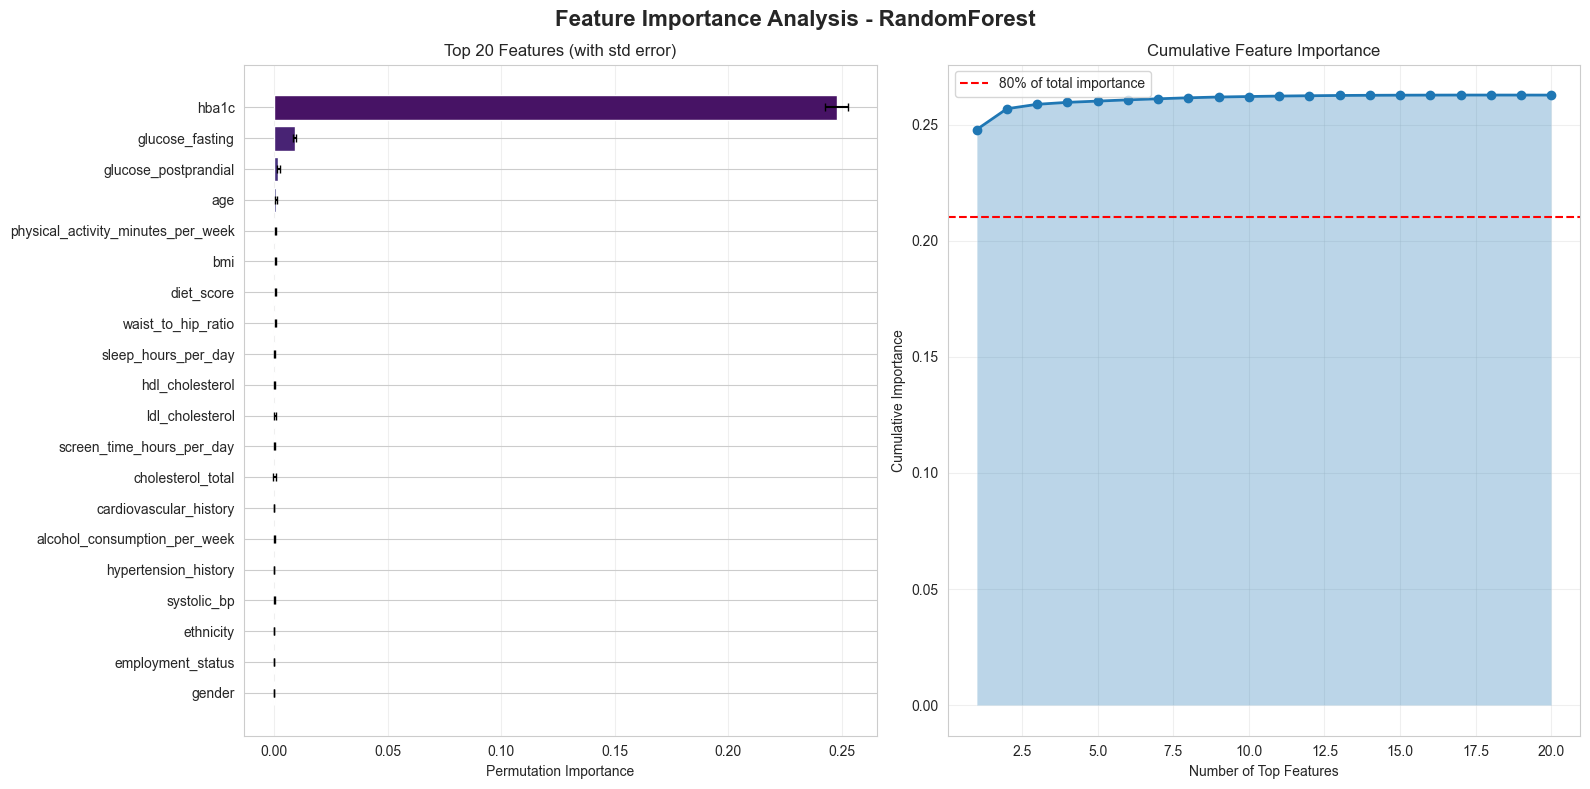


ANALYSIS COMPLETE
✓ Best Model: RandomForest
✓ Test ROC-AUC: 0.9383
✓ Test F1 Score: 0.9283
✓ All visualizations generated successfully


In [11]:
best_name = summary.iloc[0]["Model"]
best_pipe = fitted_models[best_name]

print("\n" + "=" * 80)
print(f"FEATURE IMPORTANCE ANALYSIS - {best_name}")
print("=" * 80)

print("Computing permutation importance on original features (this may take a moment)...")
r = permutation_importance(
    best_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

# use original feature names (before transformation)
original_feature_names = X_test.columns.tolist()

print(f"Number of original features: {len(original_feature_names)}")
print(f"Number of importance values: {len(r.importances_mean)}")

# verify they match
if len(original_feature_names) != len(r.importances_mean):
    print(f"⚠️  ERROR: Mismatch between features and importance values!")
    print(f"   This shouldn't happen. Using generic names as fallback.")
    original_feature_names = [f"feature_{i}" for i in range(len(r.importances_mean))]

imp_df = pd.DataFrame({
    "Feature": original_feature_names,
    "Importance": r.importances_mean,
    "Std": r.importances_std
}).sort_values("Importance", ascending=False).head(20)

print("\nTop 20 Most Important Features:")
print(imp_df.to_string(index=False))

# visualization 5: Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'Feature Importance Analysis - {best_name}', fontsize=16, fontweight='bold')

# bar plot with error bars
ax = axes[0]
y_pos = np.arange(len(imp_df))
ax.barh(y_pos, imp_df['Importance'], xerr=imp_df['Std'], 
        color=sns.color_palette("viridis", len(imp_df)), capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_df['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Permutation Importance')
ax.set_title('Top 20 Features (with std error)')
ax.grid(axis='x', alpha=0.3)

# cumulative importance
ax = axes[1]
cumsum = imp_df['Importance'].cumsum()
ax.plot(range(1, len(imp_df) + 1), cumsum, marker='o', linewidth=2, markersize=6)
ax.fill_between(range(1, len(imp_df) + 1), cumsum, alpha=0.3)
ax.set_xlabel('Number of Top Features')
ax.set_ylabel('Cumulative Importance')
ax.set_title('Cumulative Feature Importance')
ax.grid(True, alpha=0.3)
ax.axhline(y=cumsum.iloc[-1] * 0.8, color='r', linestyle='--', 
           label='80% of total importance')
ax.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print(f"✓ Best Model: {best_name}")
print(f"✓ Test ROC-AUC: {summary.iloc[0]['ROC-AUC']:.4f}")
print(f"✓ Test F1 Score: {summary.iloc[0]['F1']:.4f}")
print(f"✓ All visualizations generated successfully")
print("=" * 80)

